In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# File paths
data_dir = "/home/jmframe/data/AORC/camels/1980_to_2024/"
csv_file = f"{data_dir}1187300_1980_to_2024_agg.csv"
nc_file = f"{data_dir}1187300_1980_to_2024.nc"
# Load the new dataset
lumped_csv_path = "/home/jmframe/data/CAMELS_US/hourly/aorc_hourly/01187300_1980_to_2024_agg_rounded.csv"
# Load Lumped CSV file
print("Loading Lumped CSV file...")
df_lumped = pd.read_csv(lumped_csv_path)
df_lumped["time"] = pd.to_datetime(df_lumped["time"])  # Convert time column to datetime
print("Lumped CSV file loaded. Preview:")
print(df_lumped.head())


# Load CSV file
print("Loading CSV file...")
df_csv = pd.read_csv(csv_file)
print("CSV file loaded. Preview:")
print(df_csv.head())

# Load NetCDF file
print("\nLoading NetCDF file...")
ds_nc = xr.open_dataset(nc_file)
print("NetCDF file loaded. Preview:")
print(ds_nc)

# Optional: List all variables in the NetCDF dataset
print("\nVariables in NetCDF file:")
print(ds_nc.variables.keys())

Loading Lumped CSV file...
Lumped CSV file loaded. Preview:
                 time  APCP_surface  DLWRF_surface  DSWRF_surface  \
0 1980-01-01 00:00:00           0.0          212.9            0.0   
1 1980-01-01 01:00:00           0.0          212.5            0.0   
2 1980-01-01 02:00:00           0.0          212.0            0.0   
3 1980-01-01 03:00:00           0.0          217.7            0.0   
4 1980-01-01 04:00:00           0.0          217.1            0.0   

   PRES_surface  SPFH_2maboveground  TMP_2maboveground  UGRD_10maboveground  \
0       98190.0              0.0020              272.1                  1.4   
1       98230.0              0.0019              272.0                  1.2   
2       98270.0              0.0018              271.9                  1.0   
3       98310.0              0.0017              271.9                  0.8   
4       98270.0              0.0017              271.5                  0.9   

   VGRD_10maboveground  
0                 -2.6  


In [3]:
# Convert the time column to datetime format for easy plotting
df_csv['time'] = pd.to_datetime(df_csv['time'])
print(df_csv.info())  # Ensure time column is in datetime format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385704 entries, 0 to 385703
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   time                 385704 non-null  datetime64[ns]
 1   APCP_surface         385704 non-null  float64       
 2   DLWRF_surface        385680 non-null  float64       
 3   DSWRF_surface        385704 non-null  float64       
 4   PRES_surface         385632 non-null  float64       
 5   SPFH_2maboveground   385632 non-null  float64       
 6   TMP_2maboveground    385704 non-null  float64       
 7   UGRD_10maboveground  385704 non-null  float64       
 8   VGRD_10maboveground  385584 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 26.5 MB
None


In [4]:
# Inspect the structure of the NetCDF file
print("\nNetCDF Variables:")
for var in ds_nc.data_vars:
    print(f"{var}: {ds_nc[var].dims}")


NetCDF Variables:
APCP_surface: ('catchment-id', 'time')
DLWRF_surface: ('catchment-id', 'time')
DSWRF_surface: ('catchment-id', 'time')
PRES_surface: ('catchment-id', 'time')
SPFH_2maboveground: ('catchment-id', 'time')
TMP_2maboveground: ('catchment-id', 'time')
UGRD_10maboveground: ('catchment-id', 'time')
VGRD_10maboveground: ('catchment-id', 'time')


In [5]:
# Convert NetCDF time values (which are in hours since 1980-01-01)
time_values = pd.to_datetime("1980-01-01") + pd.to_timedelta(ds_nc["time"].values, unit="h")

# Assign corrected time values back to the NetCDF dataset
ds_nc = ds_nc.assign_coords(time=time_values)

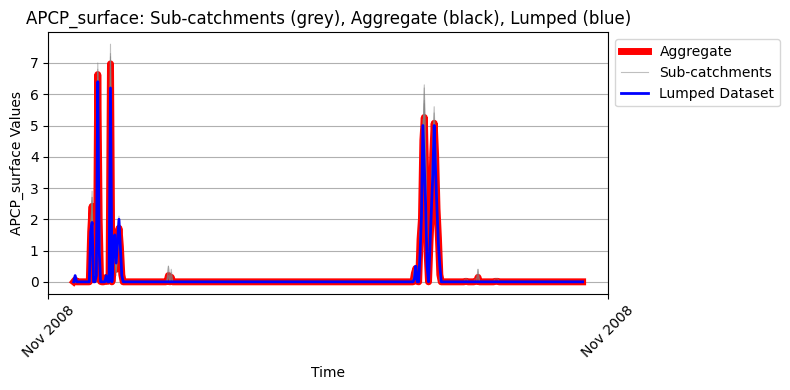

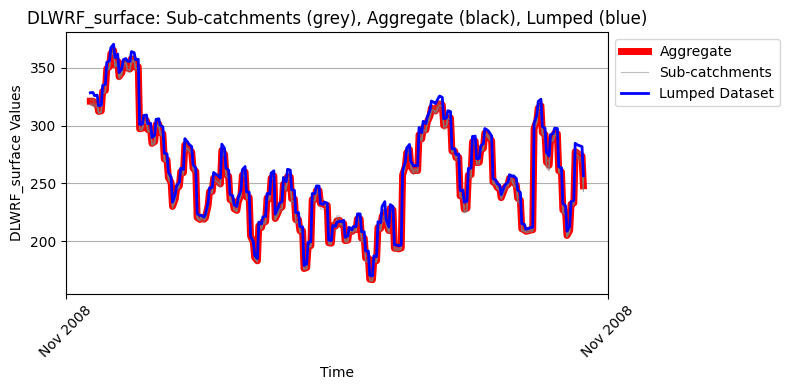

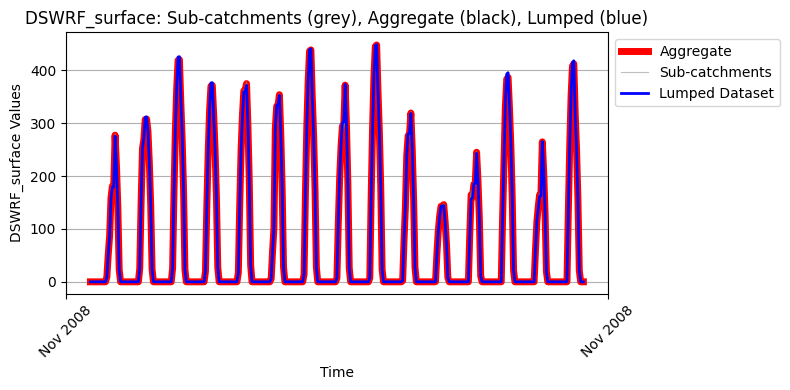

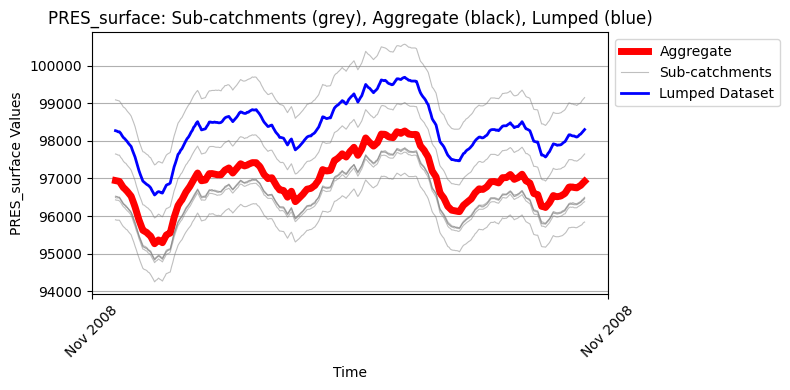

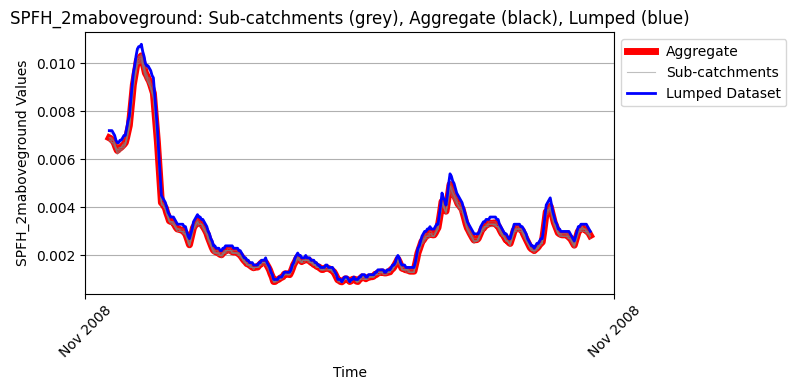

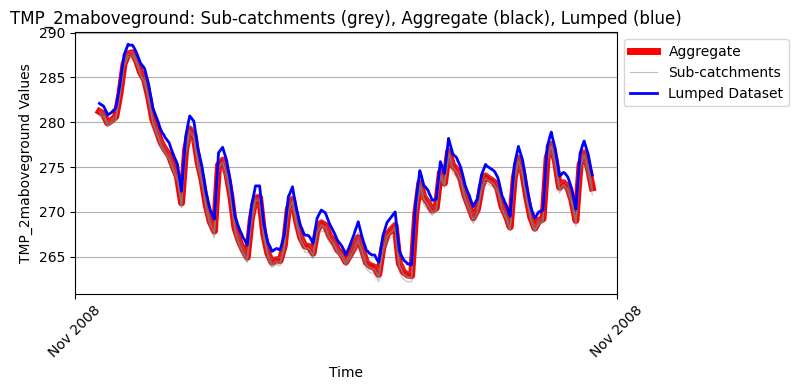

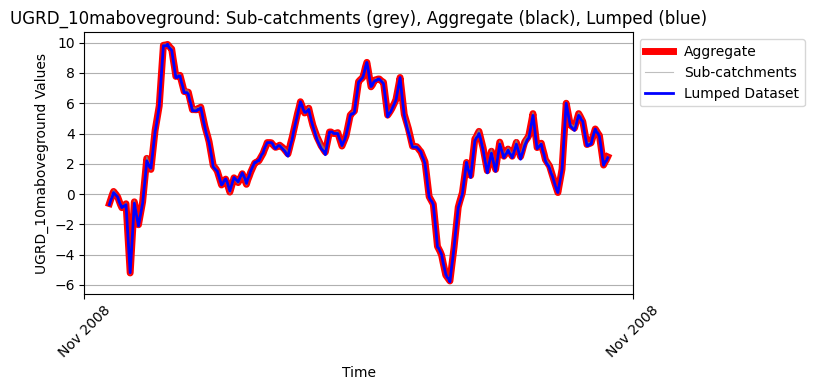

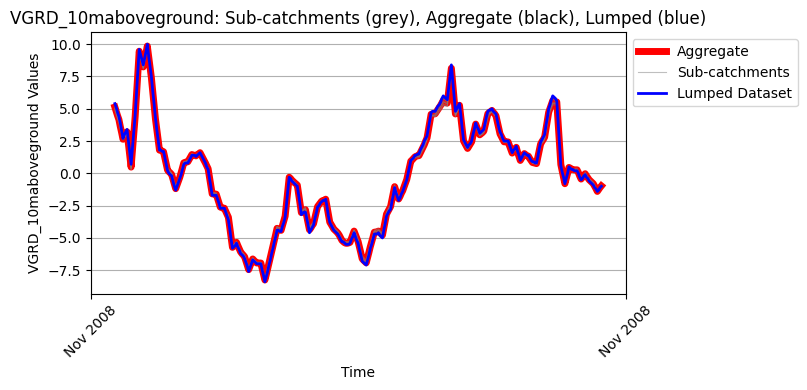

In [9]:
# Define the start and end dates for filtering
start_date = pd.to_datetime("2008-11-15")
end_date = pd.to_datetime("2008-11-30")

# Convert to pandas datetime for filtering
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)


# Iterate over each variable in the dataset
for var in ds_nc.data_vars:
    plt.figure(figsize=(8, 4))
    
    # Plot aggregate (CSV data in black)
    if var in df_csv.columns:
        mask = (df_csv["time"] >= start_date) & (df_csv["time"] <= end_date)  # Filter by date range
        plt.plot(
            df_csv["time"][mask],
            df_csv[var][mask],
            color='r',
            linewidth=5.0,
            label="Aggregate"
        )

    # Plot sub-catchments (NetCDF data in grey)
    for catchment_idx in range(ds_nc.dims["catchment-id"]):
        time_values = ds_nc["time"].values
        mask = (time_values >= start_date) & (time_values <= end_date)  # Filter by date range
        plt.plot(
            time_values[mask],
            ds_nc[var].isel({"catchment-id": catchment_idx}).values[mask],
            color='grey',
            alpha=0.5,
            linewidth=0.8,
            label=None if catchment_idx > 0 else "Sub-catchments"
        )

    # Plot Lumped dataset (Blue Line)
    if var in df_lumped.columns:
        mask = (df_lumped["time"] >= start_date) & (df_lumped["time"] <= end_date)
        plt.plot(
            df_lumped["time"][mask],
            df_lumped[var][mask],
            color='blue',
            linewidth=2.0,
            linestyle="-",
            label="Lumped Dataset"
        )

    # Add labels, title, and legend
    plt.xlabel("Time")
    plt.ylabel(f"{var} Values")
    plt.title(f"{var}: Sub-catchments (grey), Aggregate (black), Lumped (blue)")
    plt.grid(True)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    
    # Format x-axis for months and years
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show ticks for each month
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as 'Month Year'
    plt.xticks(rotation=45)  # Rotate the labels for better readability
    
    # Adjust layout for readability
    plt.tight_layout()
    
    # Display the plot
    plt.show()